# All original features" sequence logo

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import json

import sys
sys.path.append("../")
from src.sequence_logo import plot_logo
import src.quad_model

In [2]:
# Load pretrained model
model_file_name = f"../model/custom_adjacency_regularizer_20210731_124_step3.h5"
model = load_model(model_file_name)

# Weights
incl_weights, _ = model.get_layer("qc_incl").weights
skip_weights, _ = model.get_layer("qc_skip").weights

In [3]:
# Filter groups
with open("../data/model_data.json", "r") as f:
    model_data = json.load(f)
    INCL_SEQ_GROUPS = model_data["incl_seq_groups"]
    SKIP_SEQ_GROUPS = model_data["skip_seq_groups"]
    
# Sequence logo
seq_logo_data = np.load("../data/seq_logo_data.npy")

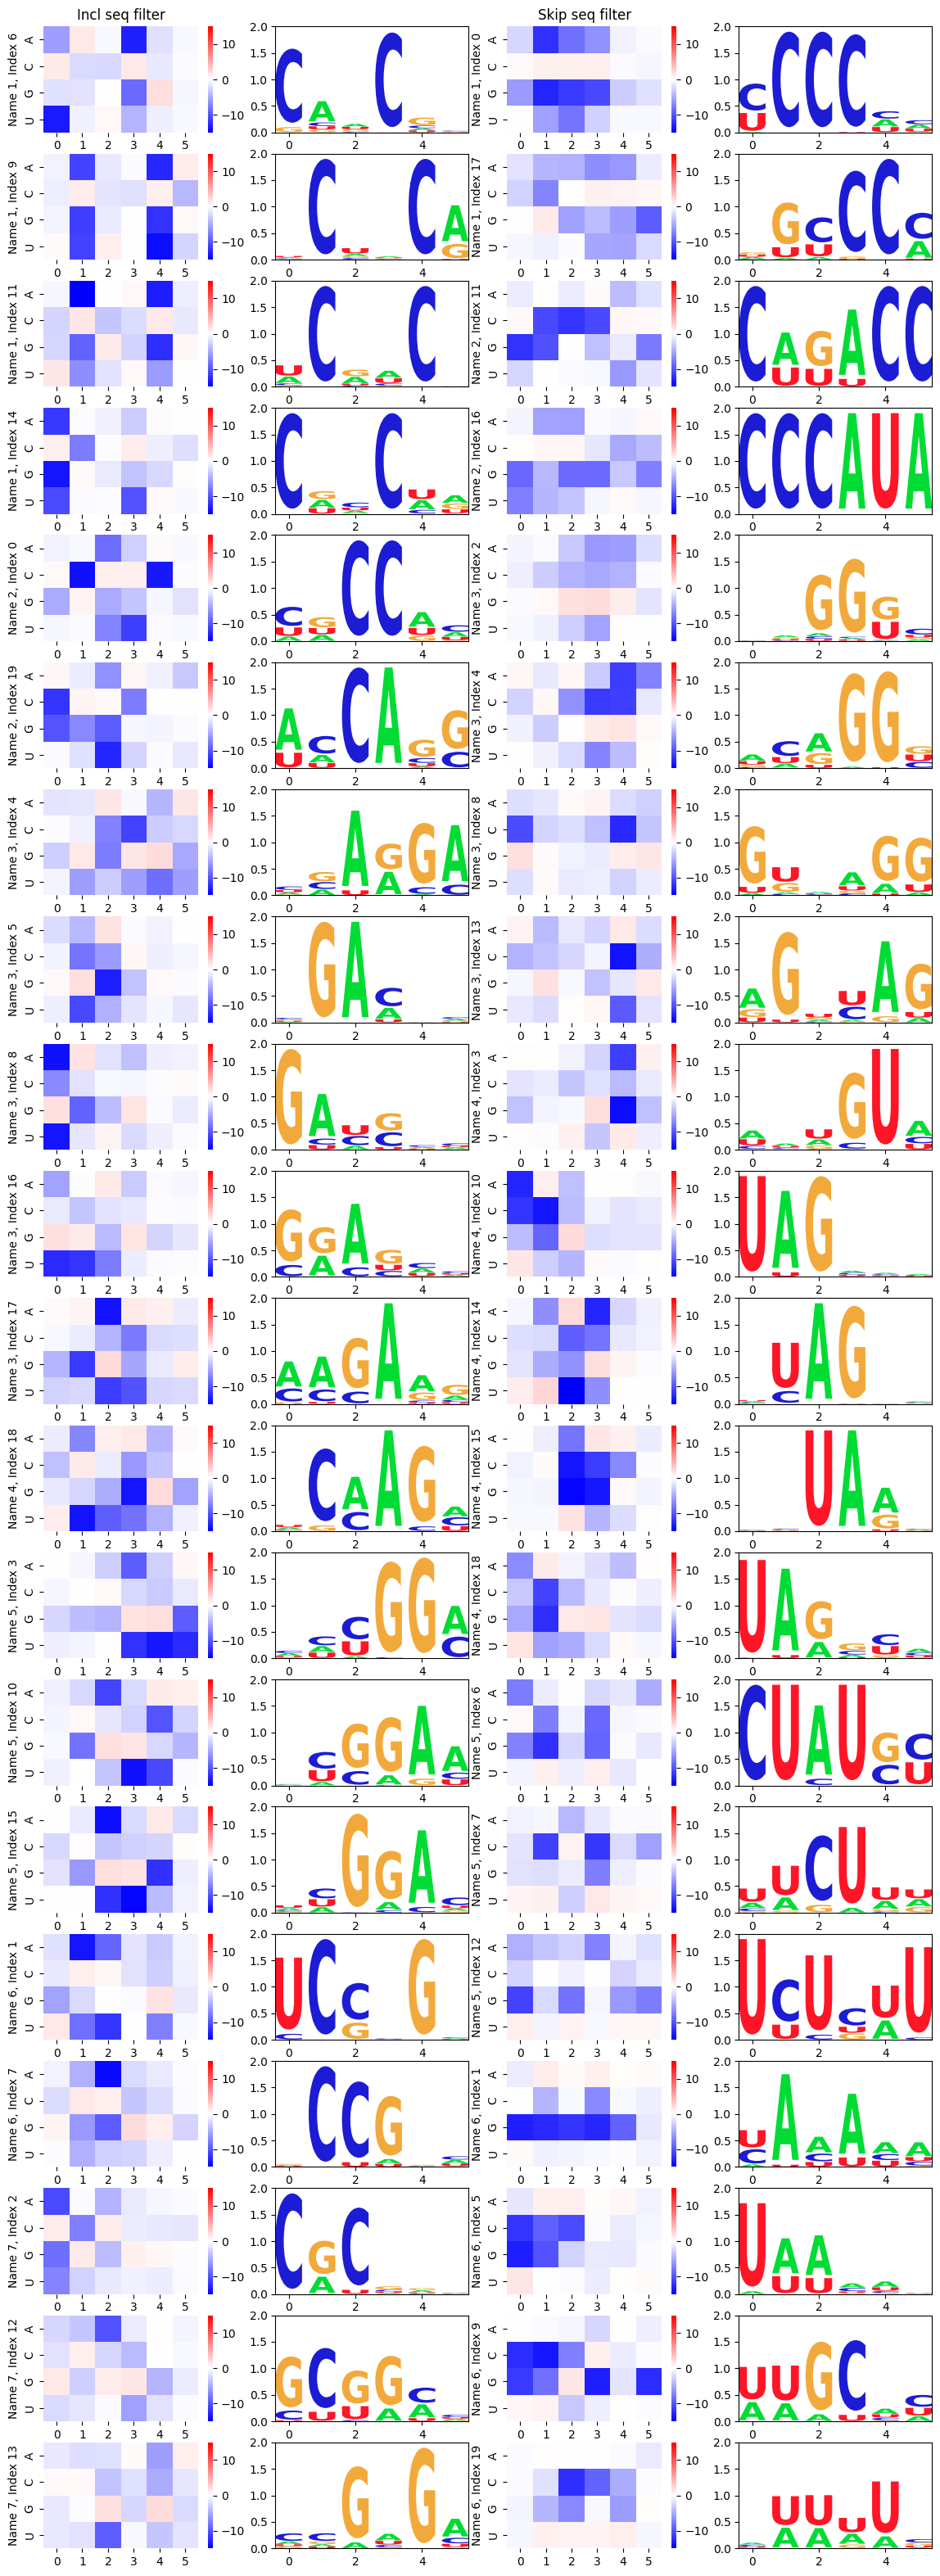

In [5]:
# All sequence logo
nts = ["A", "C", "G", "U"]
num_seq_filters = model.get_layer("qc_incl").kernel.shape[2]
fig, axes = plt.subplots(num_seq_filters, 4, figsize=(14, num_seq_filters * 2))

row = 0
axes[0,0].set_title("Incl seq filter")
for incl_filter_name in sorted(INCL_SEQ_GROUPS.keys()):
    for i in INCL_SEQ_GROUPS[incl_filter_name]:
        sns.heatmap(data=incl_weights[...,i].numpy().T, ax=axes[row,0], cmap="bwr", vmin=-15, vmax=15)
        axes[row,0].set_yticklabels(nts)
        axes[row,0].set_ylabel(f"Name {incl_filter_name}, Index {i}")
        
        data = pd.DataFrame(seq_logo_data[i,...], columns=nts)
        plot_logo(data=data, ax=axes[row,1])
        axes[row, 1].set_ylim((0, 2))
        row += 1

row = 0
axes[0,2].set_title("Skip seq filter")
for skip_filter_name in sorted(SKIP_SEQ_GROUPS.keys()):
    for i in SKIP_SEQ_GROUPS[skip_filter_name]:
        sns.heatmap(data=skip_weights[...,i].numpy().T, ax=axes[row,2], cmap="bwr", vmin=-15, vmax=15)
        axes[row,2].set_yticklabels(nts)
        axes[row,2].set_ylabel(f"Name {skip_filter_name}, Index {i}")
        
        data = pd.DataFrame(seq_logo_data[i+num_seq_filters,...], columns=nts)
        plot_logo(data=data, ax=axes[row,3])
        axes[row, 3].set_ylim((0, 2))
        row += 1

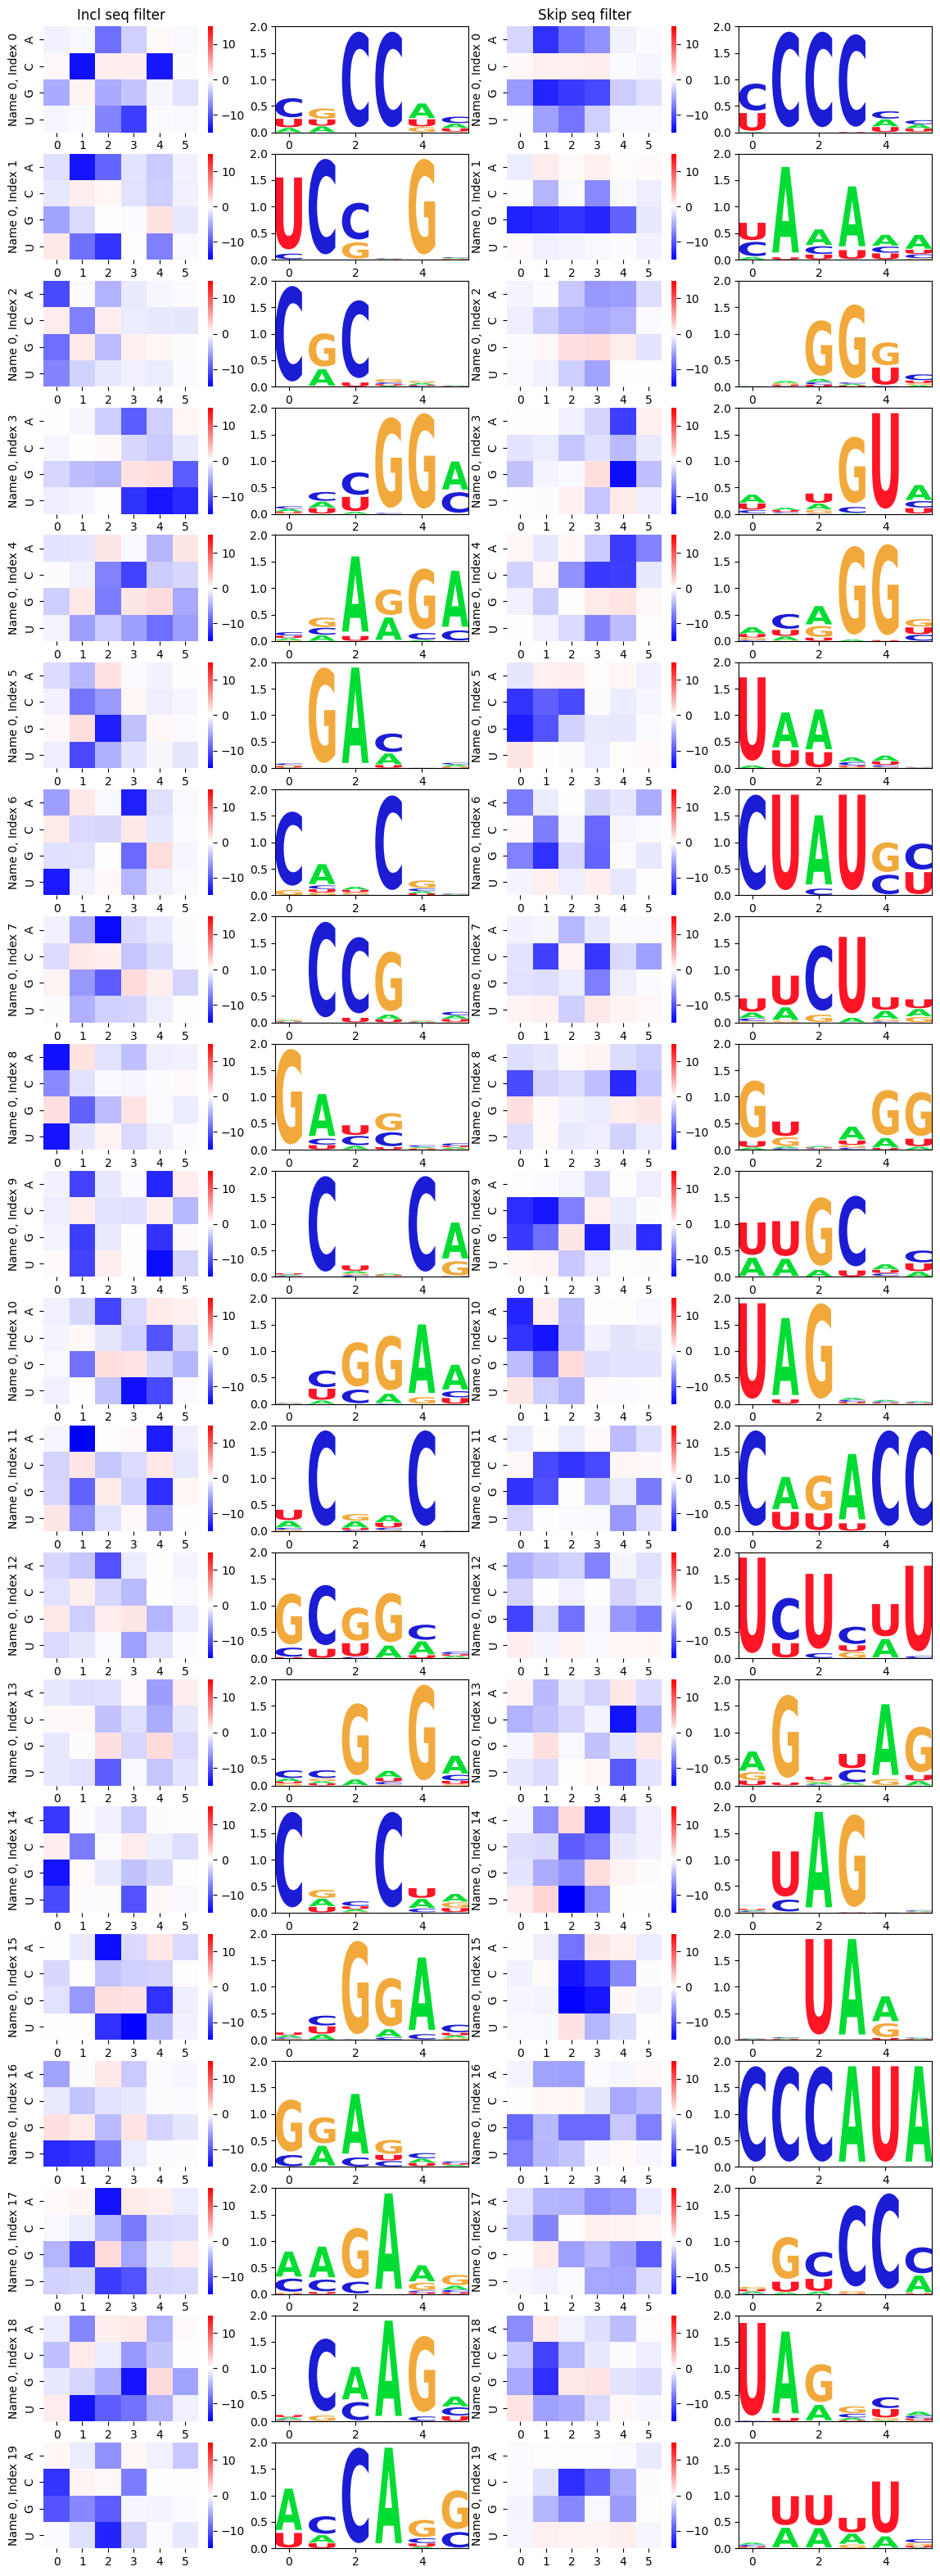

In [6]:
# All sequence logo
fig, axes = plt.subplots(num_seq_filters, 4, figsize=(14, num_seq_filters * 2))

row = 0
axes[0,0].set_title("Incl seq filter")
for i in range(num_seq_filters):
    for incl_filter_name in [0]:
        sns.heatmap(data=incl_weights[...,i].numpy().T, ax=axes[row,0], cmap="bwr", vmin=-15, vmax=15)
        axes[row,0].set_yticklabels(nts)
        axes[row,0].set_ylabel(f"Name {incl_filter_name}, Index {i}")
        
        data = pd.DataFrame(seq_logo_data[i,...], columns=nts)
        plot_logo(data=data, ax=axes[row,1])
        axes[row, 1].set_ylim((0, 2))
        row += 1

row = 0
axes[0,2].set_title("Skip seq filter")
for i in range(num_seq_filters):
    for skip_filter_name in [0]:
        sns.heatmap(data=skip_weights[...,i].numpy().T, ax=axes[row,2], cmap="bwr", vmin=-15, vmax=15)
        axes[row,2].set_yticklabels(nts)
        axes[row,2].set_ylabel(f"Name {skip_filter_name}, Index {i}")
        
        data = pd.DataFrame(seq_logo_data[i+num_seq_filters,...], columns=nts)
        plot_logo(data=data, ax=axes[row,3])
        axes[row, 3].set_ylim((0, 2))
        row += 1